### LDA 실습 - 한국어 영화 리뷰

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gensim
from gensim import corpora, models
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
# 나눔 폰트 설치: 한글 폰트 사용을 위해 설치 후 런타임 재시작 (런타임 - 세션 다시 시작) 필요할 수 있음
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 버전 차이로 인한 DeprecationWarning 경고 안 나오게 설정
import warnings
warnings.filterwarnings("ignore")

!pip install konlpy
from konlpy.tag import Komoran
import re

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd

train_data = pd.read_table('/content/gdrive/MyDrive/Colab Notebooks/BigData/data/ratings_train.txt')
test_data = pd.read_table('/content/gdrive/MyDrive/Colab Notebooks/BigData/data/ratings_test.txt')

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# 코퍼스 만들기
documents = train_data['document'].to_list()
documents = [doc for doc in documents if isinstance(doc, str)]  # 텍스트가 없는 문서 제외
documents = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc) for doc in documents]  # 한국어만 고려
# 한국어 없는 문서 제외
korean_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ가-힣]+")
documents = [doc for doc in documents if korean_pattern.search(doc)]
# 한국어가 없는 텍스트 제외
# komoran.noun() 등과 같은 전처리 함수는 '  '과 같은 공백이 입력값으로
# 들어오면 nullpointerexception 발생시키기 때문에 해당 처리 수행함
print("문서 개수:", len(documents))
print("첫번째 문서:", documents[0])

문서 개수: 148740
첫번째 문서: 아 더빙 진짜 짜증나네요 목소리


In [ ]:
# 코퍼스의 문서 단어 단위 토큰화 (시간 다소 소요)
komoran = Komoran()
doc_tokenized = [komoran.nouns(doc) for doc in documents]                                            # 명사로 토큰화
doc_tokenized = [[word for word in doc_tokens if len(word) >= 2] for doc_tokens in doc_tokenized]    # 2글자 이상 명사만 선택
print("첫번째 문서 토큰화 결과:", doc_tokenized[0])

첫번째 문서 토큰화 결과: ['더빙', '짜증', '목소리']


In [ ]:
dictionary = corpora.Dictionary(doc_tokenized)
# 적어도 5번 이상 출현한 단어
# 20% 이내 문서에서 출현한 단어만 단어집(vocabulary)으로 고려 (너무 많이 출현하여 보편적인 단어도 제거해야 함)
# 적당히 출현한 단어만
dictionary.filter_extremes(no_below=5, no_above=0.2)

words_to_exclude = ['이영화', '이다']                             # 추가로 제거하고 싶은 단어가 있으면 입력
dictionary.filter_tokens(bad_ids=[dictionary.token2id[word] for word in words_to_exclude])

BoW_corpus = [dictionary.doc2bow(doc) for doc in doc_tokenized]

print("단어집(vocabulary) 단어 수:", len(dictionary))
print("문서 수:", len(BoW_corpus))

단어집(vocabulary) 단어 수: 9152
문서 수: 148740


#### LDA 모델 적용
* 토픽수 $K=20$
* 학습데이터(코퍼스) $V=9152, D=148740$
* 하이퍼파라미터 $\alpha$, $\beta$는 값을 $1/K=0.05$

In [ ]:
lda_model = models.ldamodel.LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=20, random_state=123)

* 토픽별 단어 분포 $\phi_k$

In [ ]:
# 토픽별 단어 분포 행렬
topic_word_dist_mat = lda_model.get_topics()

print("토픽별 중요한 단어 순서대로 표현:")
pprint(lda_model.print_topics())

토픽별 중요한 단어 순서대로 표현:
[(0,
  '0.255*"연기" + 0.154*"배우" + 0.048*"현실" + 0.043*"스토리" + 0.032*"시작" + '
  '0.027*"영화로" + 0.025*"연출" + 0.021*"인상" + 0.020*"코믹" + 0.018*"평가"'),
 (1,
  '0.201*"스토리" + 0.087*"장면" + 0.068*"전개" + 0.066*"음악" + 0.043*"부족" + '
  '0.041*"극장" + 0.036*"당시" + 0.034*"배경" + 0.029*"절대" + 0.029*"감정"'),
 (2,
  '0.128*"느낌" + 0.082*"일본" + 0.074*"추천" + 0.053*"알바" + 0.040*"소름" + 0.039*"세상" '
  '+ 0.035*"라고" + 0.031*"옛날" + 0.029*"순수" + 0.029*"동안"'),
 (3,
  '0.228*"사람" + 0.093*"이야기" + 0.078*"기억" + 0.040*"공감" + 0.034*"미국" + '
  '0.029*"흥미" + 0.025*"거지" + 0.022*"후회" + 0.018*"네이버" + 0.018*"마라"'),
 (4,
  '0.126*"이건" + 0.096*"주인공" + 0.048*"억지" + 0.032*"만화" + 0.031*"영화인" + '
  '0.028*"걸작" + 0.027*"캐스팅" + 0.023*"비디오" + 0.023*"비교" + 0.021*"목소리"'),
 (5,
  '0.310*"평점" + 0.079*"마음" + 0.072*"눈물" + 0.036*"제일" + 0.032*"영화관" + '
  '0.031*"시절" + 0.023*"예술" + 0.021*"성룡" + 0.018*"한편" + 0.018*"집중"'),
 (6,
  '0.132*"최악" + 0.126*"한국" + 0.068*"인생" + 0.050*"막장" + 0.044*"우리나라" + '
  '0.043*"지루함" + 0.042*"별점" 

* 특정 토픽의 단어 분포 시각화

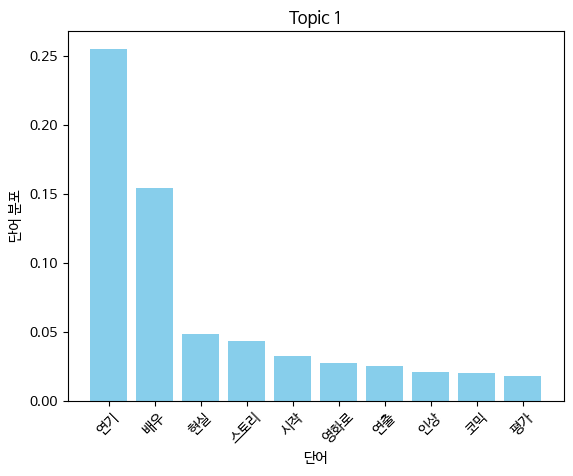

In [ ]:
topic_idx = 0                                             # 토픽 인덱스 (0부터 시작)
topic_dist = topic_word_dist_mat[topic_idx]
sorted_indices = np.argsort(topic_dist)[::-1]             # 가장 큰 분포값을 가지는 단어 순으로 정렬
words = [dictionary[idx] for idx in sorted_indices[:10]]  # 가장 큰 분포값을 가지는 10개의 중요 단어 선택
probs = topic_dist[sorted_indices[:10]]                   # 중요 단어의 분포값 가져오기
plt.figure()
plt.bar(words, probs, color='skyblue')
plt.title("Topic {}".format(topic_idx + 1))               # 토픽 인덱스에 1 더함
plt.xlabel("단어")
plt.ylabel("단어 분포")
plt.xticks(rotation=45)                                   # x축 레이블 회전
plt.show()

* 문서별 토픽분포

In [ ]:
# 문서별 토픽 분포
doc_topic_dist = lda_model[BoW_corpus]
print("첫번째 문서의 토픽 분포의 간단한 표현:")
pprint(list(doc_topic_dist)[0])

# 문서별 토픽 분포 행렬
doc_topic_dist_mat = np.zeros(shape=(len(doc_topic_dist), lda_model.num_topics), dtype=float)
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, topic_weight in doc_topics:
        doc_topic_dist_mat[doc_idx, topic_idx] = topic_weight

print("첫번째 문서의 토픽 분포:")
pprint(np.round(doc_topic_dist_mat[0,:], 3))

첫번째 문서의 토픽 분포의 간단한 표현:
[(0, 0.01250017),
 (1, 0.01250017),
 (2, 0.01250017),
 (3, 0.01250017),
 (4, 0.5124992),
 (5, 0.01250017),
 (6, 0.01250017),
 (7, 0.01250017),
 (8, 0.26249772),
 (9, 0.01250017),
 (10, 0.01250017),
 (11, 0.012500172),
 (12, 0.01250017),
 (13, 0.01250017),
 (14, 0.01250017),
 (15, 0.01250017),
 (16, 0.01250017),
 (17, 0.01250017),
 (18, 0.01250017),
 (19, 0.01250017)]
첫번째 문서의 토픽 분포:
array([0.013, 0.013, 0.013, 0.013, 0.512, 0.013, 0.013, 0.013, 0.262,
       0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013,
       0.013, 0.013])


* 특정 문서의 토픽 분포 시각화

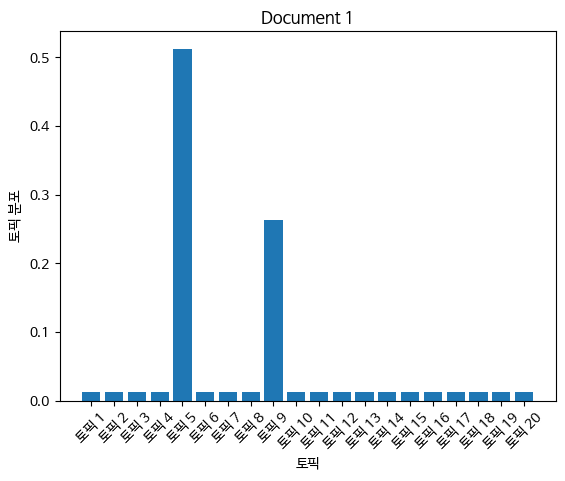

In [ ]:
doc_idx = 0                                                    # 문서 인덱스 (0부터 시작)
probs = doc_topic_dist_mat[doc_idx,:]
plt.bar(['토픽 ' + str(topic_idx+1) for topic_idx in range(lda_model.num_topics)], probs)
plt.title("Document {}".format(doc_idx + 1))                   # 문서 인덱스에 1 더함
plt.xlabel("토픽")
plt.ylabel("토픽 분포")
plt.xticks(rotation=45)                                        # x축 레이블 회전
plt.show()

#### 토픽모델 평가
* 혼란도

In [ ]:
print("학습데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus))

학습데이터 로그 혼란도: -13.02051522507716


In [ ]:
# 시험데이터 코퍼스 만들기
# 학습데이터와 전처리 똑같이 하기
documents_test = test_data['document'].to_list()
documents_test = [doc for doc in documents_test if isinstance(doc, str)]                       # 텍스트가 없는 문서는 제외
documents_test = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc) for doc in documents_test]            # 한국어만 고려
korean_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ가-힣]+")
documents_test = [doc for doc in documents_test if korean_pattern.search(doc)]                 # 한국어가 없는 텍스트 제외, komoran.noun() 등과 같은 전처리 함수는 '  '과 같은 공백이 입력값으로 들어오면 nullpointerexception 발생시키기 때문에 해당 처리 수행함
print("시험데이터 문서 개수:", len(documents_test))
print("시험데이터 두번째 문서:", documents_test[1])

# 시험데이터 코퍼스의 문서 단어 단위 토큰화 (시간 다소 소요)
komoran = Komoran()
doc_tokenized_test = [komoran.nouns(doc) for doc in documents_test]                                            # 명사로 토큰화
doc_tokenized_test = [[word for word in doc_tokens if len(word) >= 2] for doc_tokens in doc_tokenized_test]    # 2글자 이상 명사만 선택
print("시험데이터 두번째 문서 토큰화 결과:", doc_tokenized_test[1])

시험데이터 문서 개수: 49575
시험데이터 두번째 문서: 뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
시험데이터 두번째 문서 토큰화 결과: ['평점']


In [ ]:
# dictionary 는 시험데이터로 다시 만드는 것이 아니라 학습데이터와 동일해야 함
# dictionary.doc2bow의 기본값은 allow_update=False여야 함
BoW_corpus_test = [dictionary.doc2bow(doc) for doc in doc_tokenized_test]
print("시험데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus_test))
# 성능이 좋다

시험데이터 로그 혼란도: -13.04072665576404


* 응집성지수
    * 시험데이터를 응집성지수를 계산하기 위한 코퍼스로 활용
    * 토픽별로 중요한 $M=10$ 개의 단어를 이용

In [ ]:
coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='u_mass', topn=10) # 텍스트 대신 코퍼스를 받을수도 있음
print("토픽별 UMass 응집성지수", coherence_model.get_coherence_per_topic())
print("UMass 응집성지수", coherence_model.get_coherence())

토픽별 UMass 응집성지수 [-5.640489133801179, -5.4060613654335805, -10.425090378917277, -10.866409519433375, -10.596507880828945, -12.005803316040033, -7.822503552302937, -6.905517870978377, -11.9495280377681, -7.189662075823725, -7.265064361383803, -5.145949552906043, -6.872413528487437, -9.120020269193633, -9.274495103823273, -7.79422592686446, -9.276985613503568, -9.745376280938075, -9.475313278077623, -8.919377603861138]
UMass 응집성지수 -8.58483973251833


In [ ]:
coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_v', topn=10,
                                        window_size=110) # 단어의 연속된 110개의 단어 고려, 텍스트에 시험데이터의 코퍼스를 넣어준다
print("토픽별 C_v 응집성지수", coherence_model.get_coherence_per_topic())
print("C_v 응집성지수", coherence_model.get_coherence())

토픽별 C_v 응집성지수 [0.46071196195265385, 0.438803142904835, 0.2884256958256984, 0.29812048627097143, 0.2868874794925858, 0.28991364450598484, 0.2427540174822999, 0.2804596054798828, 0.28200043770291583, 0.3362302173232473, 0.29224982970121116, 0.326284775362504, 0.3637888360554589, 0.31246792116214117, 0.2864252293583919, 0.2985974284970832, 0.25208912343389234, 0.22690988644786309, 0.30473759672336254, 0.27302511900546245]
C_v 응집성지수 0.30704412173442225


In [ ]:
coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_uci', topn=10,
                                        window_size=10)
print("토픽별 UCI 응집성지수", coherence_model.get_coherence_per_topic())
print("UCI 응집성지수", coherence_model.get_coherence())

## 응집성지수를 이용하여 토픽의 수를 결정
## 많은 토픽을 사용할 수록 혼란도가 좋아지기 때문에 토픽의 수를 정할때 혼란도를 사용하지 않음

토픽별 UCI 응집성지수 [-1.555968458550273, -0.40166693206015164, -5.219178374585157, -5.625149155214076, -5.438437243215564, -6.594573948008955, -3.6836488312843616, -2.1563133094077265, -7.490764220588798, -2.314391812195494, -2.4653101940924547, -0.5148739840571191, -2.029744611159935, -3.763469740414078, -4.112307460960478, -3.4453866516190645, -3.992585927179991, -5.021726760785304, -4.122131613741762, -4.475289572544333]
UCI 응집성지수 -3.721145940083253


#### 적절한 토픽 개수의 선택

In [ ]:
log_perplexity = []
umass = []
cv = []
uci = []
topic_range = [5,10,15,20,25,30,35,40,50,60,70,80,90,100,150,200]

for num_topics in topic_range:    # 토픽 개수별 혼란도와 응집성지수 저정 (시간 다소 소요)
    # 해당 토픽 개수로 LDA 학습
    lda_model = models.ldamodel.LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=num_topics, random_state=123)

    # 시험데이터 코퍼스로 평가한 혼란도, 응집성지수 저장
    log_perplexity.append(lda_model.log_perplexity(BoW_corpus_test))
    coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='u_mass', topn=10)
    umass.append(coherence_model.get_coherence())
    coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_v', topn=10, window_size=110)
    cv.append(coherence_model.get_coherence())
    coherence_model = models.CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_uci', topn=10, window_size=10)
    uci.append(coherence_model.get_coherence())

* 혼란도 기준

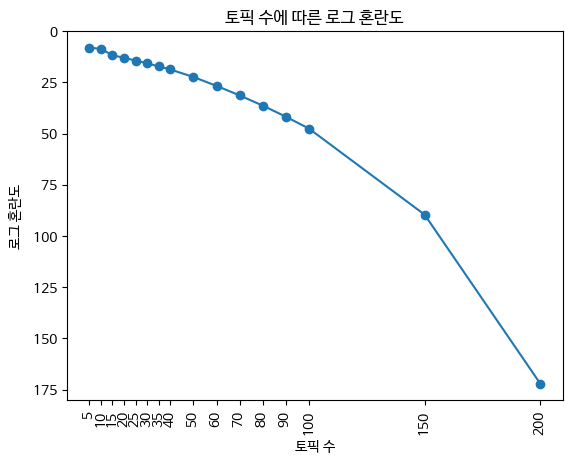

최적의 토픽 수: 200


In [ ]:
plt.plot(topic_range, log_perplexity, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("로그 혼란도")
plt.title("토픽 수에 따른 로그 혼란도")
plt.xticks(topic_range)
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

# 최적의 토픽수 찾기
optimal_num_topics = topic_range[log_perplexity.index(min(log_perplexity))]
print("최적의 토픽 수:", optimal_num_topics)

* UMass 응집성지수 기준

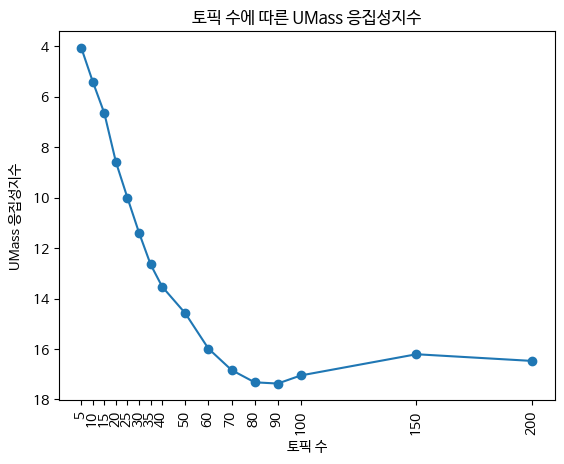

최적의 토픽 수: 5


In [ ]:
plt.plot(topic_range, umass, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("UMass 응집성지수")
plt.title("토픽 수에 따른 UMass 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)                                        # x축 레이블 회전
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[umass.index(max(umass))]  # 클수록 좋은 값
print("최적의 토픽 수:", optimal_num_topics)
# y축이 음수(표시가 안됨)

* UCI 응집성지수 기준

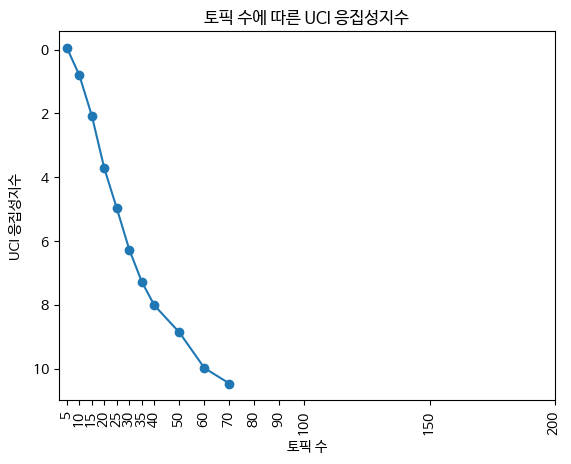

최적의 토픽 수: 80


In [ ]:
plt.plot(topic_range, uci, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("UCI 응집성지수")
plt.title("토픽 수에 따른 UCI 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)                                        # x축 레이블 회전
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[uci.index(max(uci))]
print("최적의 토픽 수:", optimal_num_topics)
# 토픽수 80개부터는 너무 세분화되어 있어서 값이 나오지 않음
## 토픽수가 많아 질수록 좋은값

* c_v 응집성지수 기준

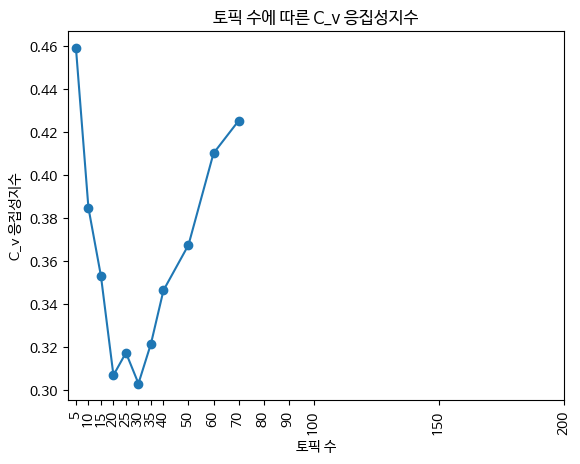

최적의 토픽 수: 5


In [ ]:
plt.plot(topic_range, cv, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("C_v 응집성지수")
plt.title("토픽 수에 따른 C_v 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)                                        # x축 레이블 회전
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[cv.index(max(cv))]
print("최적의 토픽 수:", optimal_num_topics)